# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random, create_policy_indiv_greedy

from nsai_experiments.zoning_game.notebook_utils import get_zg_data

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(DEVICE)

cuda


## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [3]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

torch.manual_seed(47)
# Not using moves data yet
states_tensor, values_tensor, _ = get_zg_data(create_policy_random, n_games = 100_000)

full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

Loading data from disk: zg_data/create_policy_random__100000
Train size: 1513124, validation size: 324240, test size: 324240


In [4]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.value_head(x)
        return x

In [5]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.002, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    torch.manual_seed(47)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 1478/1478 [00:10<00:00, 143.63it/s]


Epoch 1/5, Train Loss: 25.9855, Val Loss: 7.5978, Max Abs Diff: 26.4555, Min Abs Diff: 0.0000, Mean Abs Diff: 2.1546


100%|██████████| 1478/1478 [00:10<00:00, 140.08it/s]


Epoch 2/5, Train Loss: 7.2016, Val Loss: 5.5338, Max Abs Diff: 22.8534, Min Abs Diff: 0.0000, Mean Abs Diff: 1.8400


100%|██████████| 1478/1478 [00:10<00:00, 141.95it/s]


Epoch 3/5, Train Loss: 5.3582, Val Loss: 5.6043, Max Abs Diff: 25.5555, Min Abs Diff: 0.0000, Mean Abs Diff: 1.8572


100%|██████████| 1478/1478 [00:10<00:00, 138.86it/s]


Epoch 4/5, Train Loss: 4.4322, Val Loss: 4.3013, Max Abs Diff: 22.3686, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6378


100%|██████████| 1478/1478 [00:10<00:00, 142.05it/s]


Epoch 5/5, Train Loss: 3.7397, Val Loss: 2.4199, Max Abs Diff: 22.2296, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2130


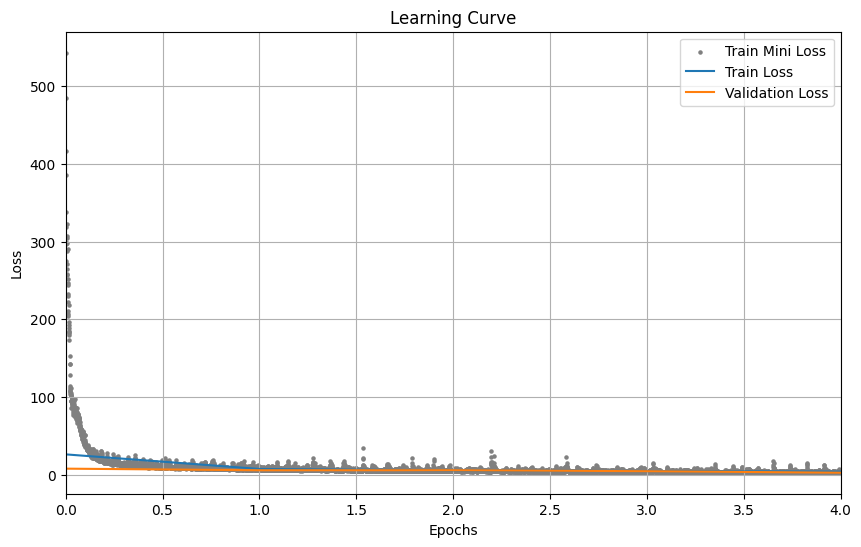

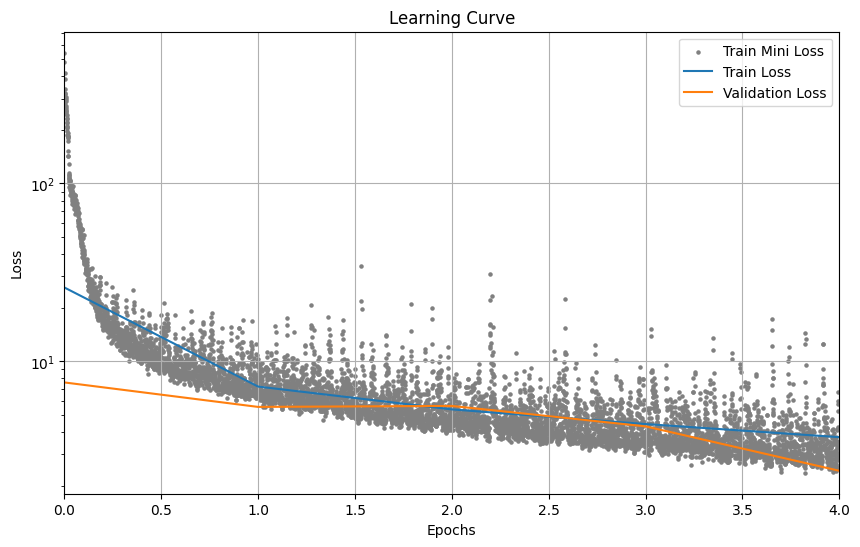

In [6]:
model = StepOneValueNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 5)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 2: no streaming, individual greedy policy, only train policy

Success. Now, same thing but we want to learn the policy, not the value. We'll try to learn the `indiv_greedy` policy.

In [7]:
states_tensor, _, moves_tensor = get_zg_data(create_policy_indiv_greedy, n_games = 100_000)

print(states_tensor.shape)
print(moves_tensor.shape)

Loading data from disk: zg_data/create_policy_indiv_greedy__100000
torch.Size([2161604, 72])
torch.Size([2161604])


In [8]:
torch.manual_seed(47)
full_dataset_2 = TensorDataset(states_tensor, moves_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset_2))
    full_dataset_2 = TensorDataset(states_tensor[indices], moves_tensor[indices])

valid_size_2 = int(valid_frac * len(full_dataset_2))
test_size_2 = int(test_frac * len(full_dataset_2))
train_size_2 = len(full_dataset_2) - valid_size_2 - test_size_2

# Perform the split
train_dataset_2, valid_dataset_2, test_dataset_2 = random_split(full_dataset_2, [train_size_2, valid_size_2, test_size_2])

print(f"Train size: {len(train_dataset_2)}, validation size: {len(valid_dataset_2)}, test size: {len(test_dataset_2)}")

Train size: 1513124, validation size: 324240, test size: 324240


In [9]:
class StepTwoPolicyNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.policy_head(x)
        return x

In [10]:
def train_step_two_policy_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 0, weight_decay = 5e-3, device = DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, ")

    return model, train_mini_losses, train_losses, valid_losses

100%|██████████| 1478/1478 [00:10<00:00, 140.23it/s]


Epoch 1/5, Train Loss: 2.7179, Val Loss: 2.4655, 


100%|██████████| 1478/1478 [00:10<00:00, 136.80it/s]


Epoch 2/5, Train Loss: 2.3764, Val Loss: 2.2874, 


100%|██████████| 1478/1478 [00:10<00:00, 138.69it/s]


Epoch 3/5, Train Loss: 2.2310, Val Loss: 2.1653, 


100%|██████████| 1478/1478 [00:10<00:00, 138.62it/s]


Epoch 4/5, Train Loss: 2.1215, Val Loss: 2.1004, 


100%|██████████| 1478/1478 [00:10<00:00, 136.44it/s]


Epoch 5/5, Train Loss: 2.0775, Val Loss: 2.0488, 


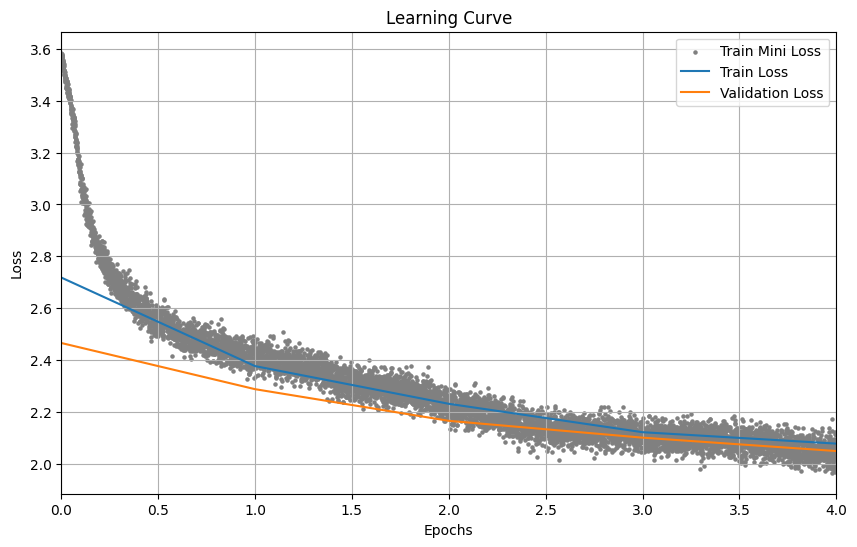

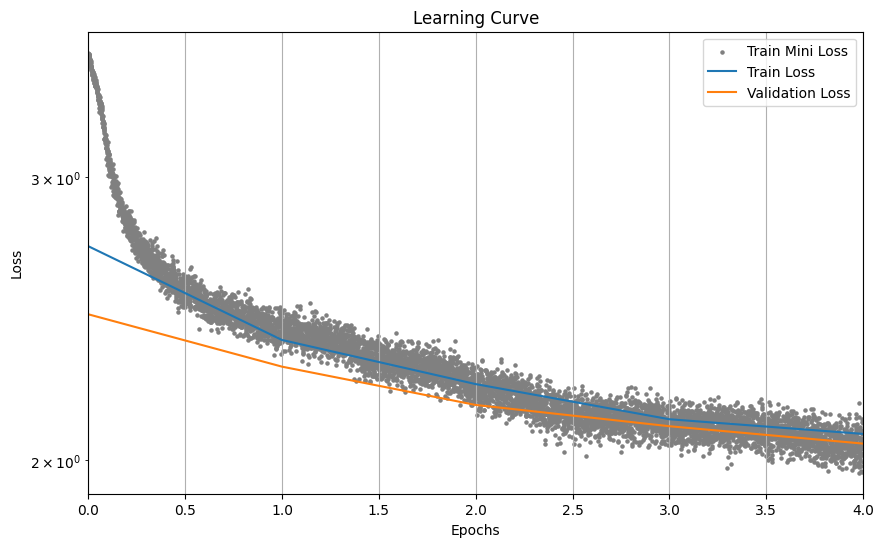

In [11]:
model = StepTwoPolicyNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_two_policy_network(model, train_dataset_2, valid_dataset_2, epochs = 5)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 3: no streaming, individual greedy policy, train both value and policy
Our value and policy nets look quite similar. Can we have one with two heads that does both?

In [12]:
states_tensor, values_tensor, moves_tensor = get_zg_data(create_policy_indiv_greedy, n_games = 100_000)

print(states_tensor.shape)
print(values_tensor.shape)
print(moves_tensor.shape)

Loading data from disk: zg_data/create_policy_indiv_greedy__100000
torch.Size([2161604, 72])
torch.Size([2161604])
torch.Size([2161604])


In [13]:
torch.manual_seed(47)
full_dataset_3  = TensorDataset(states_tensor, values_tensor, moves_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset_3))
    full_dataset_3 = TensorDataset(states_tensor[indices], values_tensor[indices], moves_tensor[indices])

valid_size_3 = int(valid_frac * len(full_dataset_3))
test_size_3 = int(test_frac * len(full_dataset_3))
train_size_3 = len(full_dataset_3) - valid_size_3 - test_size_3

# Perform the split
train_dataset_3, valid_dataset_3, test_dataset_3 = random_split(full_dataset_3, [train_size_3, valid_size_3, test_size_3])

print(f"Train size: {len(train_dataset_3)}, validation size: {len(valid_dataset_3)}, test size: {len(test_dataset_3)}")

Train size: 1513124, validation size: 324240, test size: 324240


In [14]:
class StepThreeComboNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)

        y_value = self.value_head(x)
        y_policy = self.policy_head(x)
        return y_value, y_policy

In [15]:
def train_step_three_combo_network(model, train_dataset, valid_dataset,
                                  epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 0, weight_decay = 5e-3, device = DEVICE,
                                  policy_weight = 4.0):
    model = model.to(device)
    criterion_value = nn.MSELoss()
    criterion_policy = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []
    valid_losses_value = []
    valid_losses_policy = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets_value, targets_policy in tqdm(train_loader):
            inputs, targets_value, targets_policy = inputs.to(device), targets_value.to(device), targets_policy.to(device)
            optimizer.zero_grad()
            outputs_value, outputs_policy = model(inputs)
            loss_value = criterion_value(outputs_value.squeeze(), targets_value)
            loss_policy = criterion_policy(outputs_policy.squeeze(), targets_policy)
            loss = loss_value + policy_weight*loss_policy

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_loss_value = 0.0
        valid_loss_policy = 0.0
        with torch.no_grad():
            for inputs, targets_value, targets_policy in val_loader:
                inputs, targets_value, targets_policy = inputs.to(device), targets_value.to(device), targets_policy.to(device)
                outputs_value, outputs_policy = model(inputs)
                loss_value = criterion_value(outputs_value.squeeze(), targets_value)
                loss_policy = criterion_policy(outputs_policy.squeeze(), targets_policy)
                loss = loss_value + policy_weight*loss_policy
                valid_loss += loss.item()
                valid_loss_value += loss_value.item()
                valid_loss_policy += loss_policy.item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))
        valid_losses_value.append(valid_loss_value / len(val_loader))
        valid_losses_policy.append(valid_loss_policy / len(val_loader))

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Val Value Loss: {valid_losses_value[-1]:.4f}, Val Policy Loss: {valid_losses_policy[-1]:.4f}")

    return model, train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy

def plot_learning_curves(train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, log_scale = False):
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.plot(range(len(valid_losses_value)), valid_losses_value, label='Validation Loss: Value')
    plt.plot(range(len(valid_losses_policy)), valid_losses_policy, label='Validation Loss: Policy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 1478/1478 [00:13<00:00, 111.15it/s]


Epoch 1/50, Train Loss: 74.4385, Val Loss: 23.6898, Val Value Loss: 10.0230, Val Policy Loss: 3.4167


100%|██████████| 1478/1478 [00:13<00:00, 109.81it/s]


Epoch 2/50, Train Loss: 20.5590, Val Loss: 17.3850, Val Value Loss: 5.5758, Val Policy Loss: 2.9523


100%|██████████| 1478/1478 [00:13<00:00, 107.16it/s]


Epoch 3/50, Train Loss: 15.7248, Val Loss: 13.7375, Val Value Loss: 4.4855, Val Policy Loss: 2.3130


100%|██████████| 1478/1478 [00:13<00:00, 108.47it/s]


Epoch 4/50, Train Loss: 12.5733, Val Loss: 11.3618, Val Value Loss: 3.6350, Val Policy Loss: 1.9317


100%|██████████| 1478/1478 [00:13<00:00, 107.28it/s]


Epoch 5/50, Train Loss: 10.7090, Val Loss: 11.0079, Val Value Loss: 4.0684, Val Policy Loss: 1.7349


100%|██████████| 1478/1478 [00:13<00:00, 107.72it/s]


Epoch 6/50, Train Loss: 9.7318, Val Loss: 9.5999, Val Value Loss: 2.9617, Val Policy Loss: 1.6596


100%|██████████| 1478/1478 [00:13<00:00, 108.00it/s]


Epoch 7/50, Train Loss: 9.0501, Val Loss: 8.5235, Val Value Loss: 2.1557, Val Policy Loss: 1.5920


100%|██████████| 1478/1478 [00:13<00:00, 108.60it/s]


Epoch 8/50, Train Loss: 8.4608, Val Loss: 7.8687, Val Value Loss: 1.8864, Val Policy Loss: 1.4956


100%|██████████| 1478/1478 [00:13<00:00, 107.87it/s]


Epoch 9/50, Train Loss: 7.9103, Val Loss: 8.4247, Val Value Loss: 2.5018, Val Policy Loss: 1.4807


100%|██████████| 1478/1478 [00:13<00:00, 107.35it/s]


Epoch 10/50, Train Loss: 7.5114, Val Loss: 7.0677, Val Value Loss: 1.3623, Val Policy Loss: 1.4263


100%|██████████| 1478/1478 [00:13<00:00, 107.58it/s]


Epoch 11/50, Train Loss: 7.1554, Val Loss: 6.9834, Val Value Loss: 1.4602, Val Policy Loss: 1.3808


100%|██████████| 1478/1478 [00:13<00:00, 105.68it/s]


Epoch 12/50, Train Loss: 6.8373, Val Loss: 6.9653, Val Value Loss: 1.6253, Val Policy Loss: 1.3350


100%|██████████| 1478/1478 [00:13<00:00, 107.25it/s]


Epoch 13/50, Train Loss: 6.6575, Val Loss: 6.6114, Val Value Loss: 1.4175, Val Policy Loss: 1.2985


100%|██████████| 1478/1478 [00:13<00:00, 107.44it/s]


Epoch 14/50, Train Loss: 6.4319, Val Loss: 6.8545, Val Value Loss: 1.6803, Val Policy Loss: 1.2935


100%|██████████| 1478/1478 [00:13<00:00, 107.83it/s]


Epoch 15/50, Train Loss: 6.2770, Val Loss: 6.4767, Val Value Loss: 1.3981, Val Policy Loss: 1.2697


100%|██████████| 1478/1478 [00:13<00:00, 105.64it/s]


Epoch 16/50, Train Loss: 6.1264, Val Loss: 6.6147, Val Value Loss: 1.6458, Val Policy Loss: 1.2422


100%|██████████| 1478/1478 [00:13<00:00, 107.38it/s]


Epoch 17/50, Train Loss: 5.9968, Val Loss: 5.6129, Val Value Loss: 0.6732, Val Policy Loss: 1.2349


100%|██████████| 1478/1478 [00:13<00:00, 107.29it/s]


Epoch 18/50, Train Loss: 5.9077, Val Loss: 6.3350, Val Value Loss: 1.3615, Val Policy Loss: 1.2434


100%|██████████| 1478/1478 [00:13<00:00, 106.62it/s]


Epoch 19/50, Train Loss: 5.8001, Val Loss: 5.6627, Val Value Loss: 0.7027, Val Policy Loss: 1.2400


100%|██████████| 1478/1478 [00:13<00:00, 107.10it/s]


Epoch 20/50, Train Loss: 5.7020, Val Loss: 5.5080, Val Value Loss: 0.5637, Val Policy Loss: 1.2361


100%|██████████| 1478/1478 [00:13<00:00, 107.50it/s]


Epoch 21/50, Train Loss: 5.7803, Val Loss: 5.4398, Val Value Loss: 0.5110, Val Policy Loss: 1.2322


100%|██████████| 1478/1478 [00:13<00:00, 105.70it/s]


Epoch 22/50, Train Loss: 5.5660, Val Loss: 5.6360, Val Value Loss: 0.7363, Val Policy Loss: 1.2249


100%|██████████| 1478/1478 [00:13<00:00, 106.41it/s]


Epoch 23/50, Train Loss: 5.5436, Val Loss: 5.6823, Val Value Loss: 0.8842, Val Policy Loss: 1.1995


100%|██████████| 1478/1478 [00:13<00:00, 107.12it/s]


Epoch 24/50, Train Loss: 5.6422, Val Loss: 5.1860, Val Value Loss: 0.4482, Val Policy Loss: 1.1845


100%|██████████| 1478/1478 [00:14<00:00, 104.70it/s]


Epoch 25/50, Train Loss: 5.4753, Val Loss: 5.1505, Val Value Loss: 0.3999, Val Policy Loss: 1.1876


100%|██████████| 1478/1478 [00:13<00:00, 107.34it/s]


Epoch 26/50, Train Loss: 5.3680, Val Loss: 5.6240, Val Value Loss: 0.8905, Val Policy Loss: 1.1834


100%|██████████| 1478/1478 [00:13<00:00, 106.25it/s]


Epoch 27/50, Train Loss: 5.4107, Val Loss: 5.1809, Val Value Loss: 0.4289, Val Policy Loss: 1.1880


100%|██████████| 1478/1478 [00:13<00:00, 106.53it/s]


Epoch 28/50, Train Loss: 5.2920, Val Loss: 5.5404, Val Value Loss: 0.7796, Val Policy Loss: 1.1902


100%|██████████| 1478/1478 [00:13<00:00, 106.43it/s]


Epoch 29/50, Train Loss: 5.2785, Val Loss: 5.0155, Val Value Loss: 0.3368, Val Policy Loss: 1.1697


100%|██████████| 1478/1478 [00:13<00:00, 106.80it/s]


Epoch 30/50, Train Loss: 5.2507, Val Loss: 5.0674, Val Value Loss: 0.3328, Val Policy Loss: 1.1836


100%|██████████| 1478/1478 [00:13<00:00, 106.24it/s]


Epoch 31/50, Train Loss: 5.2826, Val Loss: 5.0885, Val Value Loss: 0.3996, Val Policy Loss: 1.1722


100%|██████████| 1478/1478 [00:13<00:00, 106.85it/s]


Epoch 32/50, Train Loss: 5.1761, Val Loss: 5.1646, Val Value Loss: 0.4876, Val Policy Loss: 1.1693


100%|██████████| 1478/1478 [00:14<00:00, 105.39it/s]


Epoch 33/50, Train Loss: 5.1822, Val Loss: 4.9920, Val Value Loss: 0.2755, Val Policy Loss: 1.1791


100%|██████████| 1478/1478 [00:13<00:00, 106.43it/s]


Epoch 34/50, Train Loss: 5.1501, Val Loss: 5.0746, Val Value Loss: 0.3700, Val Policy Loss: 1.1762


100%|██████████| 1478/1478 [00:13<00:00, 106.13it/s]


Epoch 35/50, Train Loss: 5.1618, Val Loss: 5.1053, Val Value Loss: 0.4294, Val Policy Loss: 1.1690


100%|██████████| 1478/1478 [00:14<00:00, 104.89it/s]


Epoch 36/50, Train Loss: 5.0872, Val Loss: 4.8835, Val Value Loss: 0.2435, Val Policy Loss: 1.1600


100%|██████████| 1478/1478 [00:13<00:00, 105.64it/s]


Epoch 37/50, Train Loss: 5.0838, Val Loss: 4.8957, Val Value Loss: 0.2332, Val Policy Loss: 1.1656


100%|██████████| 1478/1478 [00:14<00:00, 104.45it/s]


Epoch 38/50, Train Loss: 5.1228, Val Loss: 5.1206, Val Value Loss: 0.4223, Val Policy Loss: 1.1746


100%|██████████| 1478/1478 [00:14<00:00, 104.18it/s]


Epoch 39/50, Train Loss: 5.0079, Val Loss: 4.8579, Val Value Loss: 0.2014, Val Policy Loss: 1.1641


100%|██████████| 1478/1478 [00:14<00:00, 103.09it/s]


Epoch 40/50, Train Loss: 5.0213, Val Loss: 4.9870, Val Value Loss: 0.2788, Val Policy Loss: 1.1770


100%|██████████| 1478/1478 [00:14<00:00, 105.38it/s]


Epoch 41/50, Train Loss: 5.0274, Val Loss: 5.2058, Val Value Loss: 0.5152, Val Policy Loss: 1.1726


100%|██████████| 1478/1478 [00:14<00:00, 103.59it/s]


Epoch 42/50, Train Loss: 5.0175, Val Loss: 4.7487, Val Value Loss: 0.1582, Val Policy Loss: 1.1476


100%|██████████| 1478/1478 [00:14<00:00, 105.06it/s]


Epoch 43/50, Train Loss: 5.0879, Val Loss: 5.1229, Val Value Loss: 0.4600, Val Policy Loss: 1.1657


100%|██████████| 1478/1478 [00:14<00:00, 105.20it/s]


Epoch 44/50, Train Loss: 4.9767, Val Loss: 4.8505, Val Value Loss: 0.2399, Val Policy Loss: 1.1527


100%|██████████| 1478/1478 [00:14<00:00, 103.86it/s]


Epoch 45/50, Train Loss: 4.9817, Val Loss: 4.8319, Val Value Loss: 0.1748, Val Policy Loss: 1.1643


100%|██████████| 1478/1478 [00:14<00:00, 105.55it/s]


Epoch 46/50, Train Loss: 4.9712, Val Loss: 4.8505, Val Value Loss: 0.2220, Val Policy Loss: 1.1571


100%|██████████| 1478/1478 [00:14<00:00, 104.65it/s]


Epoch 47/50, Train Loss: 4.9781, Val Loss: 4.8422, Val Value Loss: 0.2435, Val Policy Loss: 1.1497


100%|██████████| 1478/1478 [00:14<00:00, 104.20it/s]


Epoch 48/50, Train Loss: 4.9796, Val Loss: 4.9083, Val Value Loss: 0.3212, Val Policy Loss: 1.1468


100%|██████████| 1478/1478 [00:14<00:00, 104.27it/s]


Epoch 49/50, Train Loss: 4.9266, Val Loss: 4.7896, Val Value Loss: 0.1476, Val Policy Loss: 1.1605


100%|██████████| 1478/1478 [00:14<00:00, 104.43it/s]


Epoch 50/50, Train Loss: 4.9741, Val Loss: 5.1327, Val Value Loss: 0.5290, Val Policy Loss: 1.1509


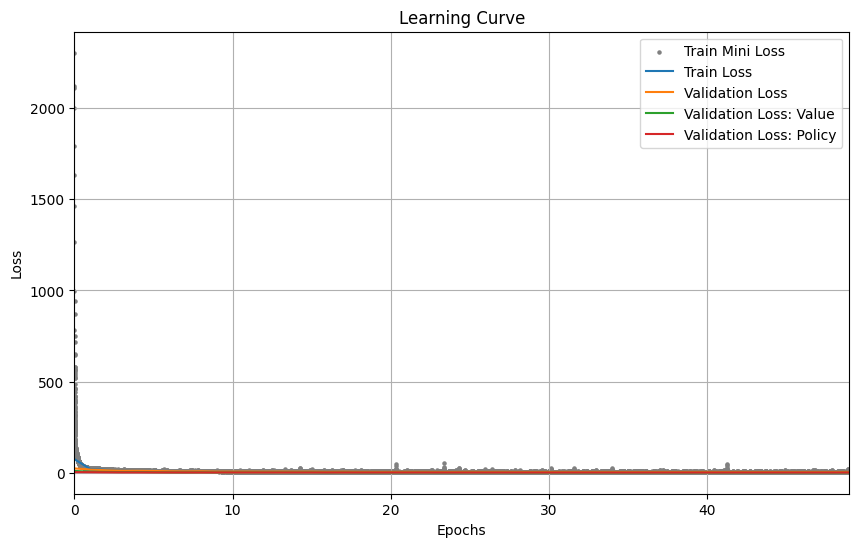

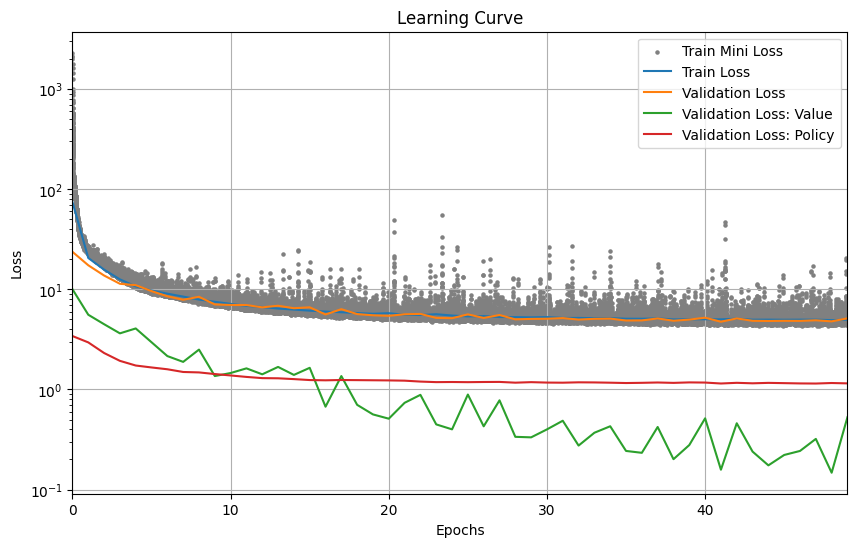

In [16]:
model = StepThreeComboNetwork()
model, train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy = train_step_three_combo_network(model, train_dataset_3, valid_dataset_3, epochs = 50)

plot_learning_curves(train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy)
plot_learning_curves(train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, log_scale = True)

Success! Next steps might include increasing `policy_weight` even more and decreasing regularization (we seem to be doing fine on not overfitting). But I think we're ready to move on to harder forms of learning!